In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import warnings
warnings.filterwarnings("ignore")

In [29]:
from scripts.data_builder import HydroForecastData
from scripts.tft_data import file_checker, open_for_tft, train_val_split

import glob
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import (TimeSeriesDataSet, TemporalFusionTransformer,
                                 Baseline)
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss, SMAPE, RMSE, MASE
from pytorch_forecasting.metrics.base_metrics import MultiHorizonMetric
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# torch.set_float32_matmul_precision('medium')
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Model

In [3]:
meteo_input = ['prcp_e5l',  't_max_e5l', 't_min_e5l']
hydro_target = 'q_mm_day'

ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')
ws_file = ws_file[ws_file['new_area'] <= 50000]


file = open_for_tft(
    nc_files=glob.glob('../geo_data/great_db/nc_all_q/*.nc'),
    static_path='../geo_data/attributes/geo_vector.csv',
    area_index=ws_file.index,
    meteo_predictors=meteo_input,
    hydro_target=hydro_target)

# define dataset
encoder_length = 365
prediction_length = 7
train_end = "2017-12-31"  # day for cutoff
train_start = "2008-01-01"
static_parameters = ['for_pc_sse', 'crp_pc_sse',
                     'inu_pc_ult', 'ire_pc_sse',
                     'lka_pc_use', 'prm_pc_sse',
                     'pst_pc_sse', 'cly_pc_sav',
                     'slt_pc_sav', 'snd_pc_sav',
                     'kar_pc_sse', 'urb_pc_sse',
                     'gwt_cm_sav', 'lkv_mc_usu',
                     'rev_mc_usu', 'sgr_dk_sav',
                     'slp_dg_sav', 'ws_area',
                     'ele_mt_sav']

file = file[['date', 'time_idx', 'gauge_id',
             hydro_target, *meteo_input, *static_parameters]]
file = file.dropna().reset_index(drop=True)


scaler = MinMaxScaler(feature_range=(1, 10))
file[[hydro_target, *meteo_input, *static_parameters]] = scaler.fit_transform(
    file[[hydro_target, *meteo_input, *static_parameters]])

train_df = file[lambda x:
                (train_start <= x.date) &
                (x.date <= train_end)].reset_index(drop=True)  # type: ignore
# set time_idx in according to slice with range from 0 to max for each gauge
train_df['time_idx'] -= train_df['time_idx'].min()
val_df = file[lambda x:
              x.date > train_end].reset_index(drop=True)  # type: ignore
# set time_idx in according to slice with range from 0 to max for each gauge
val_df['time_idx'] -= val_df['time_idx'].min()

training = TimeSeriesDataSet(
    data=train_df,
    time_idx="time_idx",
    target=hydro_target,
    group_ids=["gauge_id"],
    time_varying_unknown_reals=[hydro_target],
    max_encoder_length=encoder_length,
    max_prediction_length=prediction_length,
    static_reals=static_parameters,
    time_varying_known_reals=meteo_input,
    scalers={'name': 'None'})

validation = TimeSeriesDataSet.from_dataset(training,
                                            val_df)
# create dataloaders for model
batch_size = 128

train_dataloader = training.to_dataloader(train=True,
                                          batch_size=batch_size,
                                          num_workers=8)
val_dataloader = validation.to_dataloader(train=False,
                                          batch_size=batch_size,
                                          num_workers=8)


A Jupyter Widget

### Train model

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

class male_loss(MultiHorizonMetric):
        
    def loss(self, pred, target):
        
        pred = self.to_prediction(pred)

        return torch.mean(torch.abs(torch.log(pred) - torch.log(target)))
    


Using device: cuda



In [4]:
def interpretation_for_gauge(interp_dict: dict,
                             static_parameters: list,
                             encoder_params: list,
                             decoder_params: list):

    def to_percentage(values: torch.Tensor):
        values = values / values.sum(-1).unsqueeze(-1)
        return values

    def interp_df(interp_tensor: torch.Tensor,
                  df_columns: list):
        interp_tensor = to_percentage(interp_tensor)

        interp = {var: float(val) for var, val in zip(df_columns,
                                                      interp_tensor)}
        interp = pd.DataFrame(interp, index=[0])

        return interp

    # find most informative days
    _, indices = interp_dict['attention'].sort(descending=True)
    indices = indices[0]+1
    # get most valuable static parameters
    static_worth = interp_df(interp_tensor=interp_dict['static_variables'],
                             df_columns=static_parameters)
    stat_col, stat_val = (static_worth.idxmax(axis=1)[0],
                          static_worth.max(axis=1)[0])
    # get most valuable encoder parameters
    encoder_worth = interp_df(interp_tensor=interp_dict['encoder_variables'],
                              df_columns=encoder_params)
    enc_col, enc_val = (encoder_worth.idxmax(axis=1)[0],
                        encoder_worth.max(axis=1)[0])
    # get most valuable decoder parameters
    decoder_worth = interp_df(interp_tensor=interp_dict['decoder_variables'],
                              df_columns=decoder_params)
    dec_col, dec_val = (decoder_worth.idxmax(axis=1)[0],
                        decoder_worth.max(axis=1)[0])

    return int(indices), stat_col, enc_col, dec_col


def pred_res_builder(gauge_id: str,
                     val_ts_ds: TimeSeriesDataSet,
                     with_plot: bool = False):
    raw_prediction, _, idx = best_tft.predict(
        val_ts_ds.filter(lambda x: x.gauge_id == gauge_id),
        mode="raw",
        return_x=True,
        return_index=True)
    select_rule = (val_df.gauge_id == gauge_id) & \
        (val_df.time_idx.isin(idx['time_idx']))  # type: ignore

    idx.loc[:, 'date'] = val_df['date'][select_rule].values  # type: ignore

    res = np.array([])
    size_pred = len(raw_prediction['prediction'])  # type: ignore

    # type: ignore
    for i, prediction in enumerate(raw_prediction['prediction']):
        if i+6 == size_pred:
            break
        prediction = prediction.squeeze()  # type: ignore
        res = np.concatenate([res[:i], prediction.cpu()])
    # assemble rescaling procedure
    compare_res = val_df[val_df['gauge_id'] == gauge_id]
    compare_res = compare_res[[val in idx['time_idx'].values  # type: ignore
                               for val in compare_res['time_idx'].values]]
    compare_res['q_mm_day_pred'] = res

    with_pred = compare_res[['q_mm_day_pred',
                             *meteo_input, *static_parameters]]
    with_obs = compare_res[[hydro_target, *meteo_input, *static_parameters]]

    new_scaler = MinMaxScaler()

    new_scaler.min_, new_scaler.scale_ = scaler.min_, scaler.scale_

    # recalculate
    with_pred[['q_mm_day_pred',
               *meteo_input,
               *static_parameters]] = new_scaler.inverse_transform(with_pred)  # type: ignore
    with_obs[[hydro_target,
              *meteo_input,
              *static_parameters]] = scaler.inverse_transform(with_obs)  # type: ignore

    compare_res = compare_res[['date', 'q_mm_day', 'q_mm_day_pred']]
    compare_res['q_mm_day'] = with_obs[hydro_target]
    compare_res['q_mm_day_pred'] = with_pred['q_mm_day_pred']
    compare_res = compare_res.set_index('date')

    # get nse
    pred_nse = nse(pred=compare_res['q_mm_day_pred'],
                   target=compare_res['q_mm_day'])
    if with_plot:
        compare_res.plot()
        # get nse
        plt.title(f'NSE для поста {gauge} = {pred_nse}')

    interpretation = best_tft.interpret_output(raw_prediction, reduction="sum")
    
    attnt, static, enc, dec = interpretation_for_gauge(
        interp_dict=interpretation,
        static_parameters=static_parameters,
        encoder_params=[hydro_target, *meteo_input],
        decoder_params=meteo_input)
    
    res_df = pd.DataFrame(data={var: val for var, val in
                                zip(['NSE', 'day', 'static',
                                     'encoder', 'decoder'],
                                    [pred_nse, attnt, static, enc, dec])},
                          index=[0])
    return res_df


In [7]:
class nnse(MultiHorizonMetric):
    
    def loss(self, pred, target):
        
        pred = self.to_prediction(pred)
        denom = torch.sum((target-pred)**2)
        divsr = torch.sum((target - torch.mean(target)**2))
        nse = 1 - torch.div(denom, divsr)
        nnse = 1 / (2 - nse)
        
        return nnse
    
def nse(pred, target):
    denom = np.sum((target-pred)**2)
    divsr = np.sum((target-np.mean(target))**2)
    return 1-(denom/divsr)
    
best_tft = TemporalFusionTransformer.load_from_checkpoint('/workspaces/my_dissertation/forecast/TFT_914/lightning_logs/version_0/checkpoints/epoch=2-step=78123.ckpt')

res = list()
for gauge in tqdm(val_df.gauge_id.unique()):
    res.append(pred_res_builder(gauge_id=gauge,
                                val_ts_ds=validation,
                                with_plot=False))
res = pd.concat(res)
res.to_csv('./result/tft_predictions_256.csv',
           index=False)

A Jupyter Widget

In [33]:
best_tft = TemporalFusionTransformer.load_from_checkpoint('/workspaces/my_dissertation/forecast/TFT_test_run_2gauges/lightning_logs/version_0/checkpoints/epoch=3-step=120.ckpt')

res = list()
for gauge in tqdm(val_df.gauge_id.unique()):
    res.append(pred_res_builder(gauge_id=gauge,
                                val_ts_ds=validation,
                                with_plot=False))
res = pd.concat(res)
res.to_csv('./result/tft_predictions_test.csv',
           index=False)

A Jupyter Widget

In [12]:
pd.read_csv('./result/tft_predictions_64.csv')['NSE'].median()

0.7847846825105252

In [30]:
file = open_for_tft(
    nc_files=glob.glob('../geo_data/great_db/nc_all_q/*.nc'),
    static_path='../geo_data/attributes/geo_vector.csv',
    area_index=ws_file.index,
    meteo_predictors=meteo_input,
    hydro_target=hydro_target)

train_ds, train_loader, val_ds, val_loader = train_val_split(file)


# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss",
                                    min_delta=1e-3, patience=6, verbose=True,
                                    mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("TFT_914")  # logging results to a tensorboard
trainer = pl.Trainer(
    max_epochs=30,
    accelerator='auto',
    enable_model_summary=True,
    check_val_every_n_epoch=3,
    gradient_clip_val=0.5,
    log_every_n_steps=3,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    train_ds,
    learning_rate=1e-3,
    hidden_size=64,
    dropout=0.4,
    loss=nnse(),
    reduce_on_plateau_patience=6,
    optimizer='adam')

A Jupyter Widget

KeyboardInterrupt: 

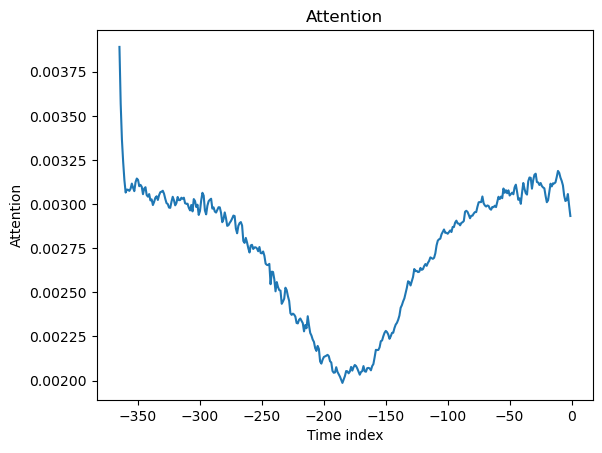

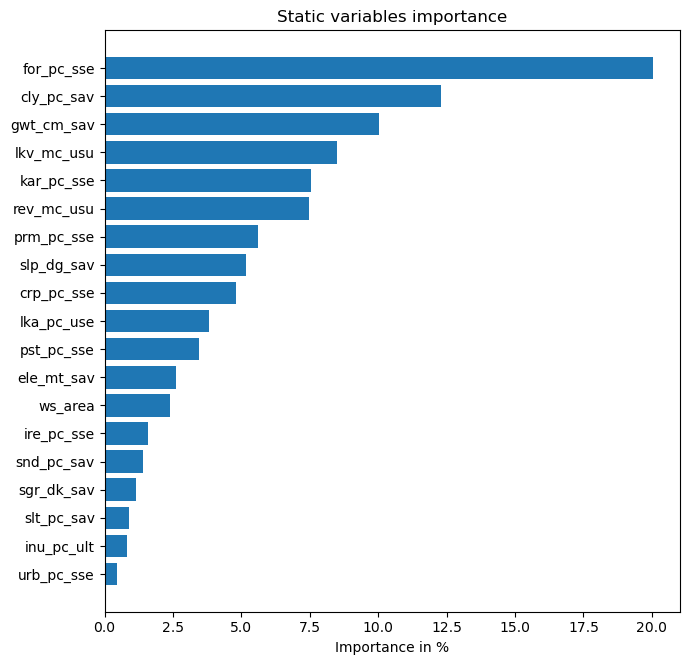

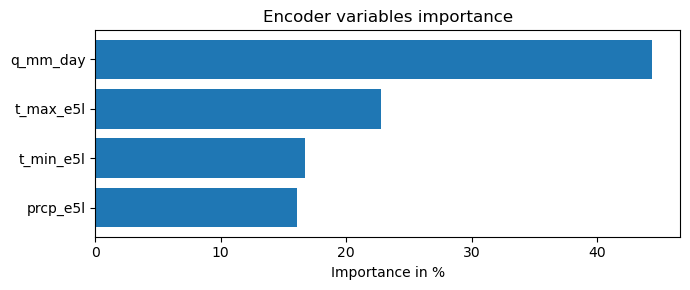

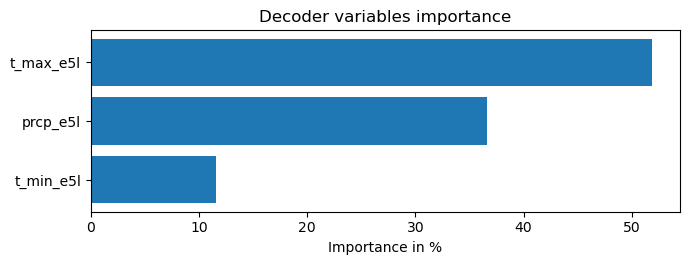

In [32]:
best_tft = TemporalFusionTransformer.load_from_checkpoint('/workspaces/my_dissertation/forecast/TFT_test_run_2gauges/lightning_logs/version_0/checkpoints/epoch=3-step=120.ckpt')
raw_predictions, x = best_tft.predict(validation.filter(
    lambda x: x.gauge_id == '76650').to_dataloader(train=False,
                                                 batch_size=batch_size,
                                                 num_workers=8), mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="mean")
best_tft.plot_interpretation(interpretation);